# Problema de Titanic


El famoso problema de Titanic consiste en, a partir de datos de los individuos involucrados en el accidente, predecir quienes se salvaron y quienes no.

En este notebook usaremos la libreria Titanic-Fairy para entrenar un modelo que pueda resolver el problema

# EDA

Los datos de la tabla que se usara de entrenamiento se puede resumir en la siguiente tabla 

| Column Name - customers.csv | Description |
|:--|:--|
| Survival | Survival (0 = No; 1 = Yes). Not included in test.csv file | 
| Pclass |  Ticket Class/ A Proxy for socio-economic status(SES) (1 = 1st/Upper ; 2 = 2nd/Middle; 3 = 3rd/Lower) | 
| Name | Name |
| Sex | Sex |
| Age | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 |
| Sibsp | Number of Siblings (brother, sister, stepbrother, stepsister) /Spouses (husband, wife (mistresses and fiancés were ignored)) Aboard |
| Parch | Number of Parents (mother, father)/Children (daughter, son, stepdaughter, stepson) Aboard; Some children travelled only with a nanny, therefore parch=0 for them. |
| Ticket | Ticket Number |
| Fare | Passenger Fare |
| Cabin | Cabin |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |

A continuacion veamos como se correlacionan algunas de estas variables

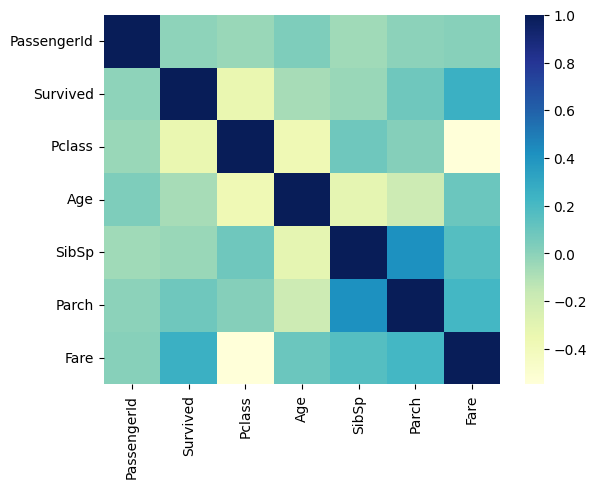

In [17]:
from titanic_fairy.helpers.load_and_save import Load
from titanic_fairy.helpers.train_test_split import stratified_split
from titanic_fairy.metrics.graphics import show_heatmap, check_train_test_split

titanic_raw_train = Load(train_path = "../dataset/train.csv")
show_heatmap(titanic_raw_train)

A primera vista, la clase y el precio del ticekt parecen influir en la supervivencia. No se ven efectos en la edad, pero esto puede deberse a un problema de escala de las variables. 

Con esto en mente reliazemos la separacion entre Train y Test. Consideramos la posibillidad de clases desbalanceadas, por lo tanto ocupamos una separacion estratificada en base a Sexo, Pclass y Supervivencia. 

En la siguiente grafica se observa que la separacion es efectivamente balanceada.


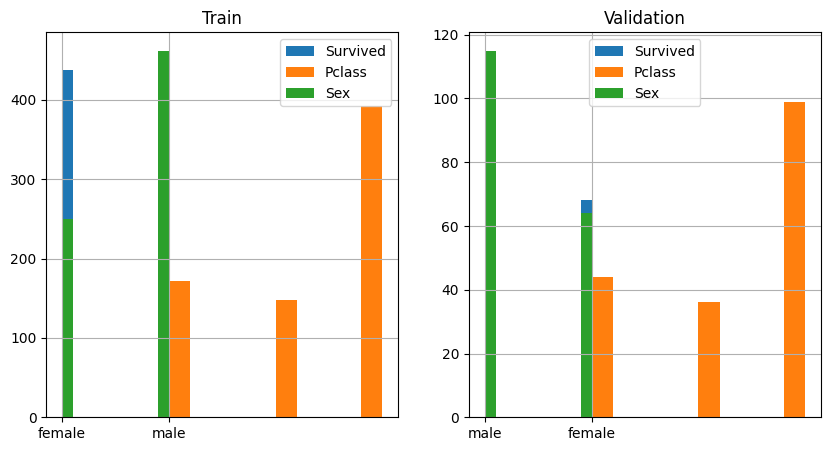

In [18]:
raw_train, raw_test = stratified_split(titanic_raw_train)

check_train_test_split(raw_train, raw_test)

# Preprocesamiento

Notemos lo siguiente

In [19]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 47 to 624
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          564 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [20]:
raw_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            148
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         2
dtype: int64

El preprocesamiento se llevara a cabo en 3 fases:

- Imputacion

Hay valores nulos en edad, cabina y embarcacion.Imputaremos estos datos (Usando promedio y la moda). Ademas necesitamos codificar correctamente la cabina,  

- Codificacion

Embarked y Sex corresponden a variables categoricas. Usaremos One-Shot-Encoding para este proposito.

- Eliminacion

Notemos que los datos de Cabina falltantes representan mucho mas del 50% de los datos, por lo que conviene desecharlos realmente. Tambien desecharemos el ID, el nombre y el ticket. El nombre puede entregar alguna info ("Mr." o "Mrs." por ejemplo ) pero asumiremos que esta informacion ya esta dentro de las otras variables (Tarifa y sexo por ejemplo). 


Estos tres pasos se peuden realizar con el wrapper de preprocesamiento de la libreria


In [21]:
raw_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C
688,689,0,3,"Fischer, Mr. Eberhard Thelander",male,18.0,0,0,350036,7.7958,NaN,S
355,356,0,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,345783,9.5000,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S


In [22]:
from titanic_fairy.preprocessing.preprocess import Preprocess

preproc_train = Preprocess().fit_transform(raw_train)
preproc_test = Preprocess().fit_transform(raw_train)

Veamos como cambio la tabla 

In [24]:
preproc_train

,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,female,male
47,1,3,29.802606,0,0,7.7500,0.0,1.0,0.0,1.0,0.0
623,0,3,21.000000,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
29,0,3,29.802606,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
630,1,1,80.000000,0,0,30.0000,0.0,0.0,1.0,0.0,1.0
266,0,3,16.000000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
209,1,1,40.000000,0,0,31.0000,1.0,0.0,0.0,0.0,1.0
688,0,3,18.000000,0,0,7.7958,0.0,0.0,1.0,0.0,1.0
355,0,3,28.000000,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
610,0,3,39.000000,1,5,31.2750,0.0,0.0,1.0,1.0,0.0


Todo se ve correcto, se desecharon las columnas que no sirven y las variables categoricas estan listas para ser usadas

# Modelamiento

Solo a modo de preuba se decidio ocupar un RandomForest, a futuro se podrian probar distintos modelos de clasificacion. 

In [23]:
from titanic_fairy.model.train_model import build_model
from titanic_fairy.enums.titanic_fields import Fields, Preprocess_

#Separamos los datos en inputs y tagrets
X_train = preproc_train.drop([Fields.Survived.value], axis=1)
y_train = preproc_train[Fields.Survived.value]

X_test = preproc_test.drop([Fields.Survived.value], axis=1)
y_test = preproc_test[Fields.Survived.value]

#Construimos el modelo 
#El pipline incluye escalamiento y ajuste del RandomForest usando GridSearch
#Los parametros del GridSearch estan especificados en Preprocess_

model = build_model(X_train, y_train)

# Resultados

Veamos los resultados en el conjunto de validacion

In [30]:
X_test = preproc_test.drop([Fields.Survived.value], axis=1)
y_test = preproc_test[Fields.Survived.value]

import numpy as np


print("La precision del modelo es de %","%.2f"  % (100*model.score(X_test, y_test))) 

La precision del modelo es de % 92.42


Al estar evaluando un modelo de clasificacion debemos tener en cuenta tanto los Flasos Negativos, como los Falsos Positivos. 

Veamos como da la matriz de confusion

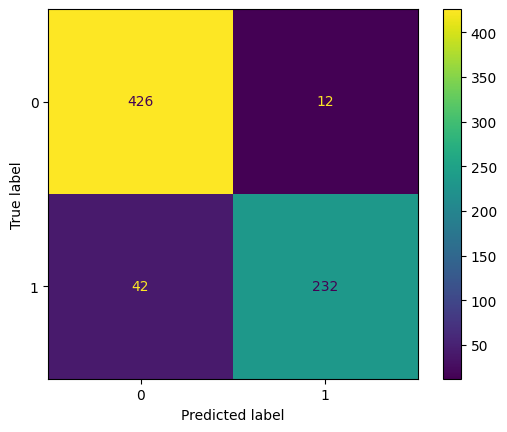

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred  = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

¿Que tan bueno es nuestro modelo? Una forma de compararlo es ocupando un modelo Dummy que siga alguna estrategia trivial de clasificacion y ver como se compara.

La precision del modelo es de % 61.52


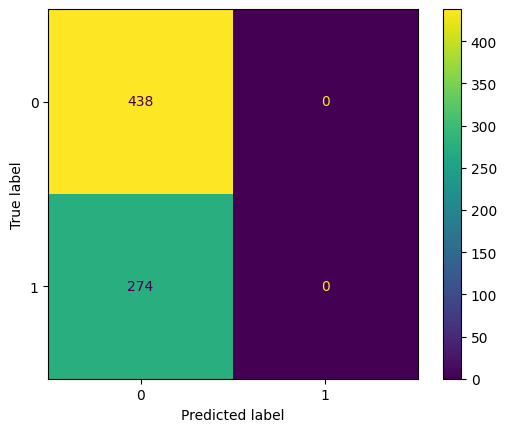

In [54]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_dummy = dummy.predict(X_test)

print("La precision del modelo es de %","%.2f"  % (100*dummy.score(X_test, y_test))) 
ConfusionMatrixDisplay.from_predictions(y_test, y_dummy_1)


De modo que al menos obtenemos un %50 de mejora respecto al modelo dummy. 

## Feature Importance

Usemos los shapley values para determinar que features resutladon ser mas importantes en el modelo.

Los shapley values son, a grandes rasgos, la contribucion marginal que realiza cada uno de los features al output del modelo 

In [67]:
import shap
import numpy as np

#La libreria Shap tiene problemas a dia de hoy
np.bool = np.bool_
np.int = np.int_

#Generamos los shapley values
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)


Exact explainer: 713it [04:47,  2.42it/s]                                                                                                        


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


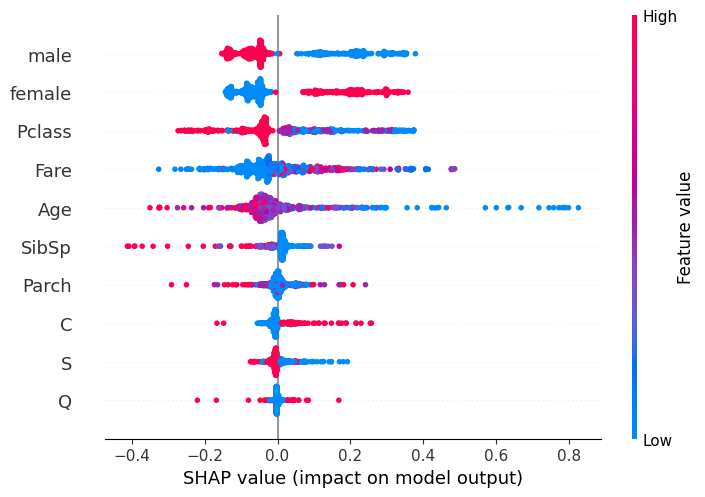

In [69]:
#Vemos que features influyen mas en el modelo 
shap.plots.beeswarm(shap_values)

Como era esperado el sexo y el valor del ticket (Pclass y Fare) explican mayormente las posibilidades de supervivencia. 

Por otro lado, la edad funciona en los extremos, pero su efecto alrededor de la media no es facil de discernir. 

El resto de variables agregan timidamente algun efecto. 

# Discusion de puesta en produccion del modelo


Para poner en produccion el modelo una buena practica es dockerizarlo (Se incluyo el Dockerfile necesario para realizar un build). 

En cuanto a la arcquitectura, dependera de si esperamos que el modelo sea consumido de manera batch o de manera online.


Si es de manera batch (Por ejemplo se necesitan predicciones cada 4 horas)podemos mantener el modelo en algun servicio y los datos en algun data warehouse. Luego cada tanto generar un archivo de predicciones y que la aplicacion vaya a buscar los resultados a ese archivo.

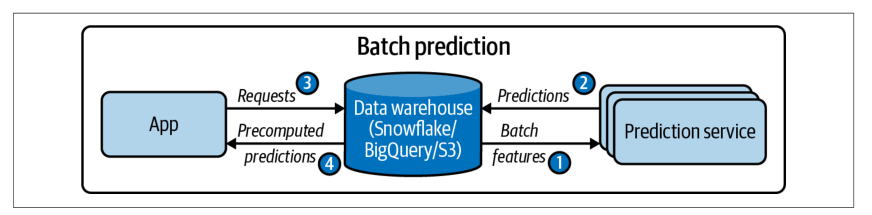

Si esperamos usuarios queriendo consumir el modelo,, entonces podemos cachear el modelo en algun servicio, implementandolo de una forma que pueda recibir requests (Como una RESTApi). Desde alli podemos usar algun servicio en la nube para escalar segun la demanda que tengamos e iremos actualizando el modelo en base a algun protocolo (contnual learning)

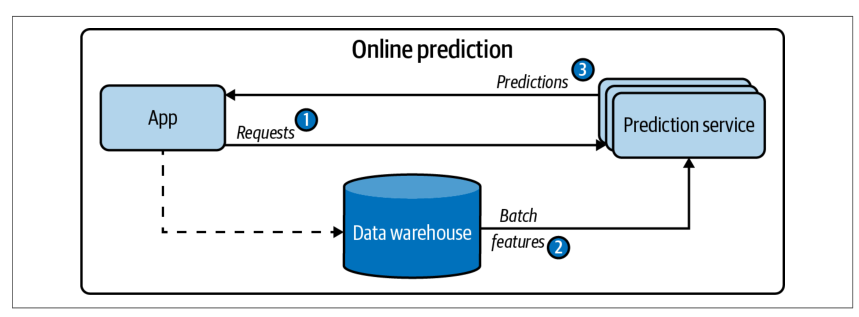
